In [499]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [500]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix, n_component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.subsample import get_subsample
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc, LOO_validation
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split
from gmr import GMM
from gmr.utils import check_random_state
from gmr import MVN
from sklearn.datasets import make_spd_matrix
from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from numpy import percentile
from scipy.stats import binned_statistic
from scipy.stats.distributions import chi2

In [501]:
data = pd.read_csv('../data/mehra.csv')
columns = data.columns.tolist()
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [502]:
data

,Treatment,SproutN,BunchN,GrapeW,WoodW,SPAD06,NDVI06,SPAD08,NDVI08,Acid,Potass,Brix,pH,Anthoc,Polyph
0,T8b,-0.024292,-0.586966,-0.899764,0.033749,0.103225,-0.086061,0.017900,-0.169745,0.063473,0.002719,0.063663,0.012567,0.125654,0.183070
1,T2b,0.050041,-0.183173,-0.060256,0.392190,0.265600,0.161536,0.209129,0.037667,-0.292480,0.091249,0.048620,0.117321,-0.250286,-0.066847
2,T7b,0.290626,1.102717,1.119642,0.121322,0.024326,0.150335,0.085781,0.185094,0.005325,-0.276571,-0.023624,-0.011758,0.064647,0.367146
3,T4b,-0.093101,-0.598244,-0.576037,-0.051983,-0.125209,0.043662,0.088573,0.045876,-0.096188,-0.164706,0.040966,0.016691,0.249739,-0.192147
4,T6b,0.036238,-0.282622,-0.527552,-0.286420,-0.032482,-0.157269,-0.041638,-0.403866,-0.039083,0.036017,-0.019958,0.015746,0.107479,0.155337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,T2a,-0.402468,-0.605394,-1.177523,-0.929616,-0.111477,-0.074208,-0.270649,-0.104261,0.310882,-0.159241,0.008462,-0.079647,0.592347,0.514770
9996,T4b,-0.309361,-0.861410,-0.614646,-0.356151,-0.164184,0.004549,-0.153423,0.069357,-0.187956,-0.122543,-0.030264,-0.015067,-0.483274,-0.731731
9997,T1b,-0.014488,-0.181456,0.577202,1.113623,0.162742,0.080877,0.088615,0.219562,-0.251131,0.012876,-0.028722,0.041994,-0.480069,-0.560375
9998,T6b,0.208087,0.379347,0.416380,-0.013353,0.079704,0.016461,0.070865,0.158818,-0.071004,-0.048707,0.006313,-0.000960,0.070482,0.065929


In [503]:
node_types = get_nodes_type(data)
node_types

{'Treatment': 'disc',
 'SproutN': 'cont',
 'BunchN': 'cont',
 'GrapeW': 'cont',
 'WoodW': 'cont',
 'SPAD06': 'cont',
 'NDVI06': 'cont',
 'SPAD08': 'cont',
 'NDVI08': 'cont',
 'Acid': 'cont',
 'Potass': 'cont',
 'Brix': 'cont',
 'pH': 'cont',
 'Anthoc': 'cont',
 'Polyph': 'cont'}

In [504]:
node_signs = get_nodes_sign(data)
node_signs

{'SproutN': 'neg',
 'BunchN': 'neg',
 'GrapeW': 'neg',
 'WoodW': 'neg',
 'SPAD06': 'neg',
 'NDVI06': 'neg',
 'SPAD08': 'neg',
 'NDVI08': 'neg',
 'Acid': 'neg',
 'Potass': 'neg',
 'Brix': 'neg',
 'pH': 'neg',
 'Anthoc': 'neg',
 'Polyph': 'neg'}

In [505]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if node_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [506]:
data_coded, label_coder = code_categories(data, 'label', colums_for_code)
data_discrete, coder = discretization(data_coded, 'kmeans', columns_for_disc)
data_only_discrete, discrete_coder = discretization(data, 'equal_frequency', columns_for_disc)

In [507]:
data_plot = np.transpose([data['ssr'].values])

In [508]:
ll = []
bic = []
aic = []
for i in range(1,11,1):
    gm = GaussianMixture(n_components=i, random_state=0)
    gm.fit(data_plot)
    ll_current = gm.lower_bound_
    bic_current = gm.bic(data_plot)
    aic_current = gm.aic(data_plot)
    ll.append(ll_current)
    bic.append(bic_current)
    aic.append(aic_current)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'BIC')

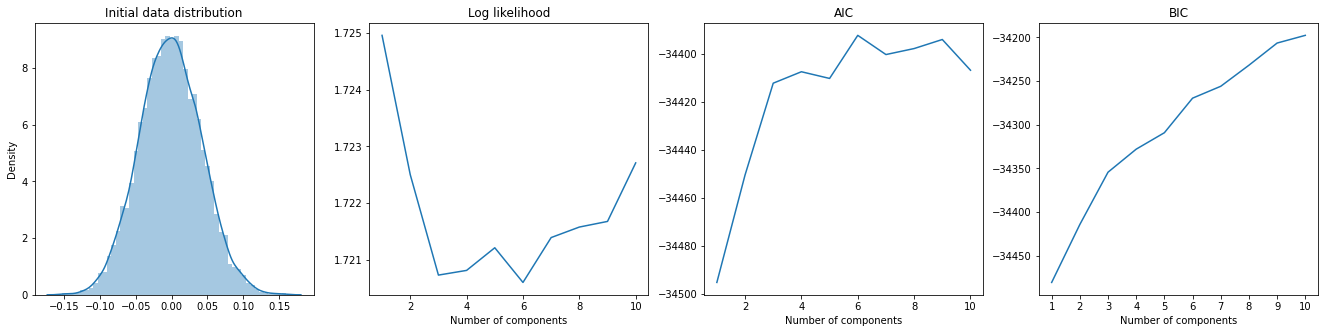

In [509]:
fig, axes = plt.subplots(1, 4, figsize=(23,5))


sns.distplot(data_plot, ax = axes[0])
axes[0].set_title('Initial data distribution')

axes[1].plot([i for i in range(1,11,1)], ll)
plt.xticks([i for i in range (1, 11, 1) ], [i for i in range (1, 11, 1)])
axes[1].set_xlabel('Number of components')
axes[1].set_title('Log likelihood')

axes[2].plot([i for i in range(1,11,1)], aic)
plt.xticks([i for i in range (1, 11, 1) ], [i for i in range (1, 11, 1)])
axes[2].set_xlabel('Number of components')
axes[2].set_title('AIC')

axes[3].plot([i for i in range(1,11,1)], bic)
plt.xticks([i for i in range (1, 11, 1) ], [i for i in range (1, 11, 1)])
axes[3].set_xlabel('Number of components')
axes[3].set_title('BIC')

In [510]:
def LRTS(data):
    n = 0
    p_val = []
    labels = []
    for i in range (1, 10, 1):
        gm1 = GaussianMixture(n_components=i, random_state=0)
        gm2 = GaussianMixture(n_components=i+1, random_state=0)
        gm1.fit(data)
        ll1 = np.mean(gm1.score_samples(data))
        gm2.fit(data)
        ll2 = np.mean(gm2.score_samples(data))
        LR = 2*(ll2 - ll1)
        p = chi2.sf(LR, 1)    
        p_val.append(p)
        labels.append('('+str(i)+','+str(i+1)+')')
    return p_val, labels

In [511]:
p, label = LRTS(data_plot)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'p_values of LRTS')

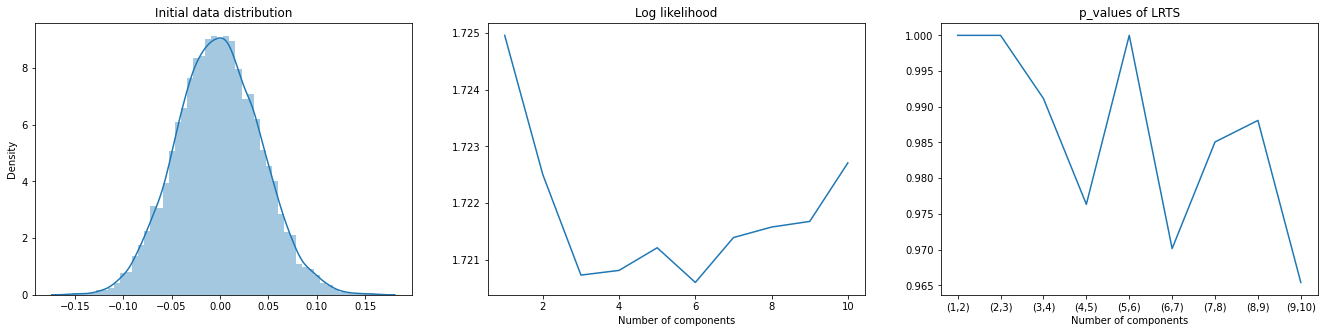

In [512]:
fig, axes = plt.subplots(1, 3, figsize=(23,5))


sns.distplot(data_plot, ax = axes[0])
axes[0].set_title('Initial data distribution')

axes[1].plot([i for i in range(1,11,1)], ll)
plt.xticks([i for i in range (1, 11, 1) ], [i for i in range (1, 11, 1)])
axes[1].set_xlabel('Number of components')
axes[1].set_title('Log likelihood')

axes[2].plot([i for i in range(len(p))], p)
plt.xticks([i for i in range (len(p)) ], label)
axes[2].set_xlabel('Number of components')
axes[2].set_title('p_values of LRTS')


In [513]:
def mix_norm_cdf(x, weights, means, covars):
    mcdf = 0.0
    for i in range(len(weights)):
        mcdf += weights[i] * stats.norm.cdf(x, loc=means[i][0], scale=covars[i][0][0])
    return mcdf

In [514]:
def quantile_mix(p, data, n_comp):
    model = GaussianMixture(n_components=n_comp)
    model.fit(data)
    q = []
    x = []
    d = np.arange((np.min(model.sample(100000)[0])), (np.max(model.sample(100000)[0])), 1000000)
    for i in d:
        x.append(i)
        q.append(mix_norm_cdf(i,model.weights_, model.means_, model.covariances_))
    ind = q.index(min(q, key=lambda x:abs(x-p)))
    return(x[ind])

In [515]:
def probability_mix(val, data, n_comp):
    model = GaussianMixture(n_components=n_comp)
    model.fit(data)
    q = []
    x = []
    d = np.arange((np.min(model.sample(100000)[0])), (np.max(model.sample(100000)[0])), 1000000)
    for i in d:
        x.append(i)
        q.append(mix_norm_cdf(i,model.weights_, model.means_, model.covariances_))
    ind = x.index(min(x, key=lambda x:abs(x-val)))
    return(q[ind])

In [516]:
mcdf = [[] for i in range(3)]
x = [[] for i in range(3)]
n_comp = [1, 2, 3]
for j, n in enumerate(n_comp):
    model = GaussianMixture(n_components=n).fit(data_plot)
    d = np.arange((np.min(model.sample(100000)[0])), (np.max(model.sample(100000)[0])), 1000000)
    for i in d:
        mcdf[j].append(mix_norm_cdf(i,model.weights_, model.means_, model.covariances_))
        x[j].append(i)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Mix cdf with 3 component')

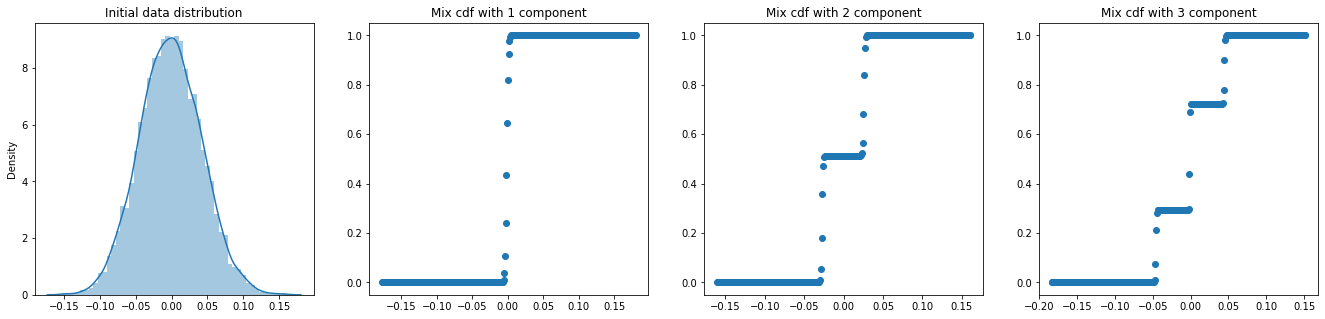

In [517]:
fig, axes = plt.subplots(1, 4, figsize=(23,5))


sns.distplot(data_plot, ax = axes[0])
axes[0].set_title('Initial data distribution')

axes[1].scatter(x[0], mcdf[0])
axes[1].set_title('Mix cdf with 1 component')

axes[2].scatter(x[1], mcdf[1])
axes[2].set_title('Mix cdf with 2 component')

axes[3].scatter(x[2], mcdf[2])
axes[3].set_title('Mix cdf with 3 component')

In [518]:
def sum_dist(data, n_comps):
    percs = np.linspace(1, 100, 10)
    x = np.quantile(data, percs/100)
    y = []
    for q in percs:
        y.append(quantile_mix(q/100, data, n_comps))
    dist = 0
    for xi,yi in zip(x,y):
        dist = dist + (abs(-1*xi + yi)) / math.sqrt(2)
    return dist

In [519]:
dists = []
for i in range (1, 11 ,1):
    dists.append(sum_dist(data_plot, i))

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


([<matplotlib.axis.XTick at 0x2a51ab6bee0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

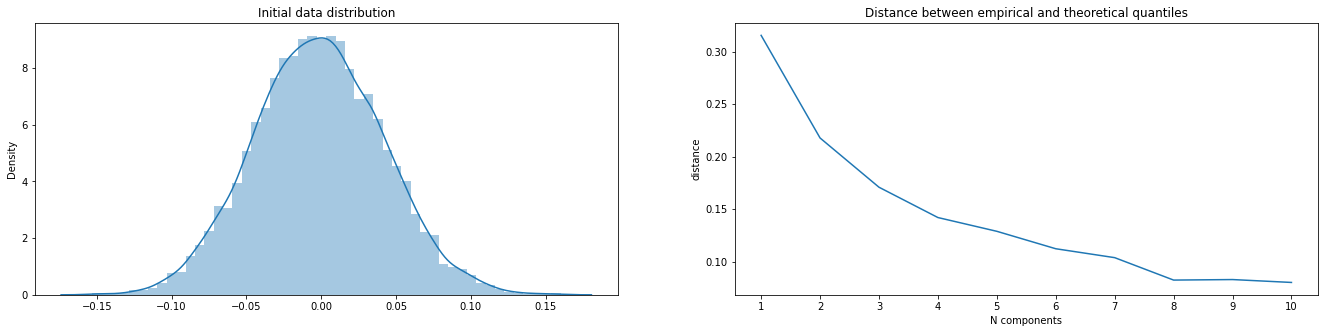

In [520]:
fig, axes = plt.subplots(1, 2, figsize=(23,5))


sns.distplot(data_plot, ax = axes[0])
axes[0].set_title('Initial data distribution')

axes[1].plot([i for i in range(1,11,1)], np.transpose(dists))
axes[1].set_title('Distance between empirical and theoretical quantiles')
axes[1].set_xlabel('N components')
axes[1].set_ylabel('distance')
plt.xticks([(i+1) for i in range (10) ], [(i+1) for i in range (10) ])

In [521]:
np.mean(data_plot)

-0.0016810326015688716

In [522]:
dists

[0.3156962274722152,
 0.21782464865758783,
 0.1708603974346921,
 0.14194454213461094,
 0.12881237484793967,
 0.11218680303106346,
 0.10368958665890857,
 0.08229878221967554,
 0.0827962362249834,
 0.08004293712859734]

In [523]:
p_val = []
for i in range(10):
    p_val.append(probability_mix(dists[i], data_plot, i+1))

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


([<matplotlib.axis.XTick at 0x2a51acdaaf0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

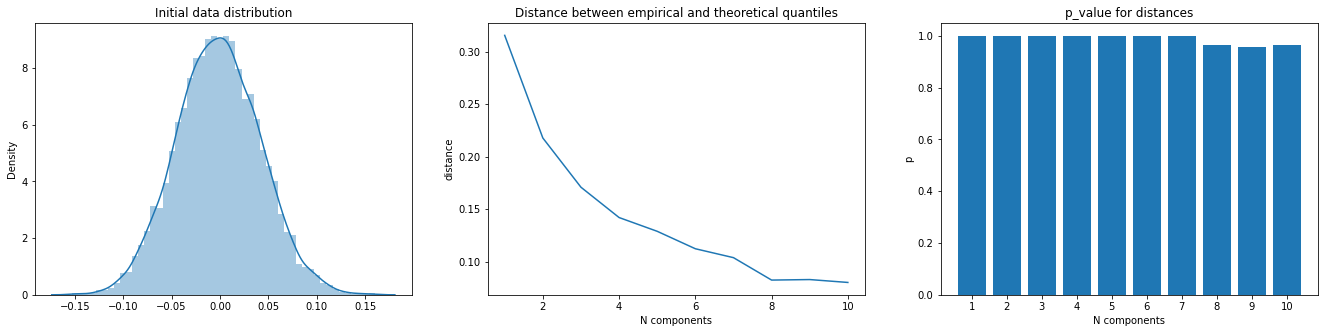

In [524]:
fig, axes = plt.subplots(1, 3, figsize=(23,5))


sns.distplot(data_plot, ax = axes[0])
axes[0].set_title('Initial data distribution')

axes[1].plot([i for i in range(1,11,1)], np.transpose(dists))
axes[1].set_title('Distance between empirical and theoretical quantiles')
axes[1].set_xlabel('N components')
axes[1].set_ylabel('distance')
plt.xticks([(i+1) for i in range (10) ], [(i+1) for i in range (10) ])


axes[2].bar([i for i in range(1,11,1)], p_val)
axes[2].set_title('p_value for distances')
axes[2].set_xlabel('N components')
axes[2].set_ylabel('p')
plt.xticks([(i+1) for i in range (10) ], [(i+1) for i in range (10) ])